# Optimization

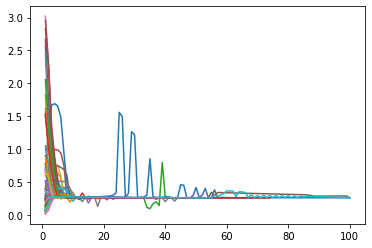

optimal design variable:
   capture_width      39.980 [m]
   pen_diameter       21.779 [m]
   pen_height         11.622 [m]
   spacing           132.767 [m]
   stock_density      42.134 [kg/m^3]
   pen_depth          96.051 [m]
----------------------------------------
optimal objective function terms:
   cost_per_yield      0.260 [$/kg]
   price          2903045.778 [$]
   fish_yield     11163948.705 [kg]
----------------------------------------


In [54]:
import modules
import numpy as np
import importlib
importlib.reload(modules)
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from functools import partial


def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

class OpObj(object):
    def __init__(self, bnds, x_name, p):
        self.x_name, self.p = x_name, p
        x0 = []
        for i in range(len(bnds)):
            x0.append(np.random.uniform(low=bnds[i][0], high=bnds[i][1]))
        self.x0 = x0
        self.f = np.full(shape=(500,), fill_value=np.NaN)
        self.count = 0
        
    def obj_fun(self, x):
        return modules.obj(x, self.x_name, self.p)

def cb(xk, obj=None):
    obj.f[obj.count] = obj.obj_fun(xk)
    obj.count += 1
    
# design variables
x_name = ['x_wec','x_pen']
x_list = modules.variable_lookup(x_name)
x_list_default_values = modules.default_values(x_name)
x_list_bnds_values = modules.bnds_values(x_name)
x0 = []
x0_unit = []
x0_bnds = []
for i in range(len(x_list)):
    x0.append(x_list_default_values[x_list[i]][0])
    x0_unit.append(x_list_default_values[x_list[i]][1])
    x0_bnds.append(x_list_bnds_values[x_list[i]])

# parameters
wec_types = ['point absorber'] #['attenuator','terminator','point absorber']

# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

default_vars = []
for i in range(len(all_vars)):
    if all_vars[i] not in x_name:
        default_vars.append(all_vars[i])

p_list = modules.variable_lookup(default_vars)
p_list_default_values = modules.default_values(default_vars)
p = {}
p_unit = []
for i in range(len(p_list)):
    p[p_list[i]] = p_list_default_values[p_list[i]][0]
    p_unit.append(p_list_default_values[p_list[i]][1])

# simulation
J = modules.obj(x0, x_name, p)

#optimization
fig, ax = plt.subplots(1,1)

opt_idx = 0
res={}
opt_res_history = []
iteration_history = []

for i in range(len(wec_types)):
    p['wec_type'] = wec_types[i]
    
    iteration = np.linspace(1,500,500)
    
    for n_test in range(100):
        op_obj = OpObj(x0_bnds, x_name, p)    

        arguments = (x_name, p)

        cons = ({'type': 'ineq', 'fun': modules.ineq_constraint, 'args': arguments},
                {'type': 'eq', 'fun': modules.eq_constraint, 'args': arguments})
        
        res[i] = minimize(modules.obj, op_obj.x0, 
                          args=arguments, 
                          method='SLSQP', 
                          bounds=x0_bnds, 
                          constraints=cons, 
                          callback=partial(cb, obj=op_obj))

        if res[i].fun < res[opt_idx].fun:
            opt_idx = i
            
        ax.plot(iteration, op_obj.f)
        
        opt_res_history.append(op_obj.f)
        iteration_history.append(op_obj.count)

#ax.set_ylim((0.339,0.340))
plt.show()

col_width = len(max(x_list, key=len))
print_bold("optimal design variable:")
for i in range(len(x_list)):
    print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x0_unit[i])
print("-"*40)

print_bold("optimal objective function terms:")
cost_per_yield, price, fish_yield = modules.obj_terms(res[opt_idx].x, x_name, p)
print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')
print("-"*40)

# Plot fish growth and fish oxygen demand

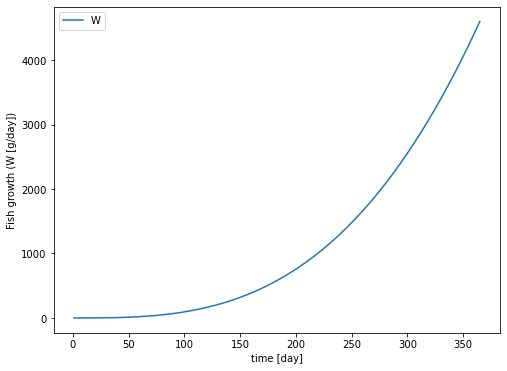

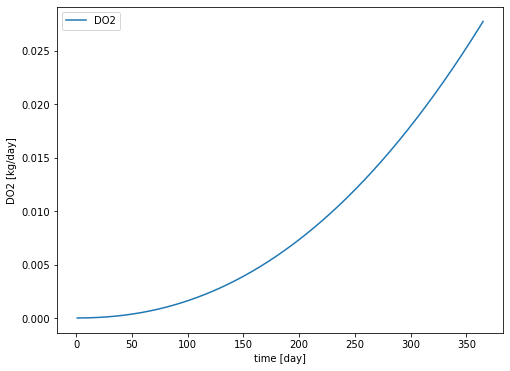

In [51]:
x_opt = res[opt_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

In [52]:
total_iter = len(obj_trend)
obj_out = np.zeros(total_iter)
obj_ineq_const = np.zeros([total_iter,len(obj_trend[0][2])])
for i in range(total_iter):
    obj_out[i] = obj_trend[i][1]
    obj_ineq_const[i] = obj_trend[i][2]
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(obj_out, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)

IndexError: list index out of range

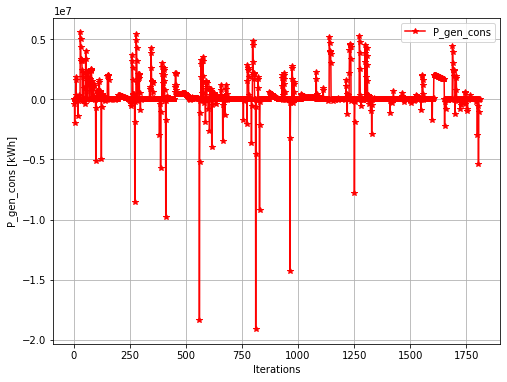

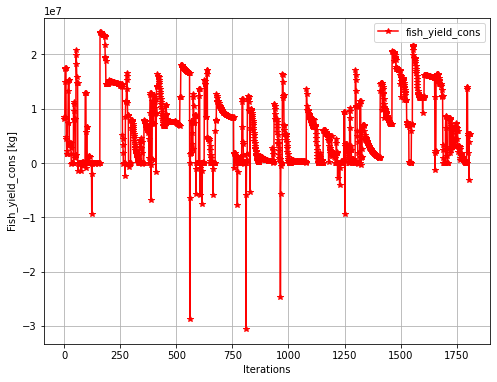

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(obj_ineq_const[:,0], 'r', label='P_gen_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax.legend()
ax.grid(True)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(obj_ineq_const[:,1], 'r', label='fish_yield_cons', marker='*')
ax.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax.legend()
ax.grid(True)

# Plot fitness 

In [13]:
x0_bnds

[(1, 40), (3, 50), (5, 30), (50, 300), (1, 50), (25, 120)]

In [14]:
len(x0_bnds)

6